In [182]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
# %matplotlib inline
%matplotlib qt

In [183]:

def load_data(game, date):
    game_db = '{}.db'.format(game)
    conn = sqlite3.connect(game_db)
    df_broadcasters = pd.read_sql_query("SELECT id, created_at, dedication FROM user_db where created_at<'{}'".format(date), conn)
    df_edges = pd.read_sql_query("SELECT source,target,date FROM edges_db where date< '{}'".format(date), conn)
    
    return df_broadcasters, df_edges

def preprocess_data(df_broadcasters, df_edges):
    
    df_edges = get_source_outdegree(df_edges)

    # 'indegree', indegree removing outdegree-1 nodes', 'rank removing outdegree-1 nodes'
    followers_distribution = get_followers_distribution_data(df_edges)
    df_broadcasters = get_indegree(df_broadcasters, followers_distribution)
    
    # get different rank by indegree, indegree removing outdegree-1 nodes'
    cols = ['indegree', 'indegree_removing_outdegree_1_nodes']
    df_broadcasters = get_rank(df_broadcasters, cols)
    
    
    
    return df_broadcasters, df_edges


def data2filter(df_broadcasters, df_edges, filtering):
    df_broadcasters_filter = df_broadcasters.loc[(df_broadcasters['dedication']>=filtering['dedication']) & (pd.to_datetime(df_broadcasters['created_at']) < filtering['date']) ]
    df_edges_filter = df_edges.loc[(pd.to_datetime(df_edges['Date']) < filtering['date']) & (df_edges['Target'].isin(df_broadcasters_filter.loc[:,'Id'].values))]
    
    # some broadcasters didn't have edge, when df_edges['Date']) < filtering['date'])
    # Therefore, N(broadcasters) in df_edges_filter <= N(broadcasters) in df_broadcasters_filter
    # So, we need to get df_broadcasters_filter again, 
    df_broadcasters_filter = df_broadcasters_filter.loc[ (df_broadcasters_filter['Id'].isin(df_edges_filter['Target'])) ]
    
    return df_broadcasters_filter, df_edges_filter


def print_data_info(df_broadcasters, df_edges, df_broadcasters_filter, df_edges_filter, filtering):

    df_dates = df_edges['Date'].sort_values()
    df_dates_filter = df_edges_filter['Date'].sort_values()

    print('Total number of broadcaster: ' + str(df_broadcasters.groupby('Id').size().size))
    print('Date of first edge: ' + str(pd.to_datetime(df_dates.head(1).item())))
    print('Date of last edge: ' + str(pd.to_datetime(df_dates.tail(1).item())))
    print('Total number of edges: ' + str(len(df_edges)))
    print('Total number of unique followers: ' + str(df_edges['Source'].nunique()))
    print('---------------------------------------------------') 
    print('After applying a filter on:') 
    print('dedication >=: ' + str(filtering['dedication']))
    print('data of edge: ' + filtering['date'])
    print('---------------------------------------------------') 
    print('Total number of broadcaster: ' + str(df_broadcasters_filter.groupby('Id').size().size))
    print('Date of first edge: ' + str(pd.to_datetime(df_dates_filter.head(1).item())))
    print('Date of last edge: ' + str(pd.to_datetime(df_dates_filter.tail(1).item())))
    print('Total number of edges: ' + str(len(df_edges_filter)))
    print('Total number of unique followers: ' + str(df_edges_filter['Source'].nunique()))
    

def get_source_outdegree(df_edges): 
    # compute source outdegree 
    followers_outdegree = df_edges.groupby("Source", as_index=False)["Target"].count()
    followers_outdegree = followers_outdegree.rename(columns={'Target':'Source_outdegree'})
    df_edges = df_edges.merge(followers_outdegree, on='Source')
    
    return df_edges


def get_followers_distribution_data(df_edges):
    
    # for each target, count how many outdegree-1,2,...,n followers it has.
    followers_distribution = df_edges.groupby(['Target','Source_outdegree'], as_index=False).size()
    followers_distribution = followers_distribution.rename(columns={'size':'Source_outdegree_count'})
    
    return followers_distribution

def get_indegree(df_broadcasters, followers_distribution):

    df_indegree = followers_distribution.groupby('Target', as_index=False)['Source_outdegree_count'].sum()
    
    # change the count of followers_distribution['Source_outdegree'] = 1 to 0, 
    followers_distribution.loc[followers_distribution['Source_outdegree'] == 1,'Source_outdegree_count'] = 0
    df_indegree_removing_outdegree_1_nodes= followers_distribution.groupby('Target', as_index=False)['Source_outdegree_count'].sum()

    # rename column name to make merge with df_broadcasters
    df_indegree = df_indegree.rename(columns={'Target':'Id', 'Source_outdegree_count': 'indegree'})
    df_indegree_removing_outdegree_1_nodes = df_indegree_removing_outdegree_1_nodes.rename(columns={'Target':'Id', 'Source_outdegree_count': 'indegree_removing_outdegree_1_nodes'})

    
    df_broadcasters = df_broadcasters.merge(df_indegree, on='Id')
    df_broadcasters = df_broadcasters.merge(df_indegree_removing_outdegree_1_nodes, on='Id')


    return df_broadcasters

def get_rank(df_broadcasters, cols):
    # sort by 'column', oder by desc, add 'Rank' columns to df_broadcasters
    for col in cols:
        df_broadcasters.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)
        df_broadcasters['Rank_{}'.format(col)] = df_broadcasters.index + 1
        
    return df_broadcasters


#  plot zipf

In [276]:
from scipy import stats

def linear_reg_log(x, y):
    pearson_coeff, p_value = stats.pearsonr(x, y)
    LR_model = np.polyfit(x, y, deg=1)
    slope_log, intercept_log = LR_model

    LR_eq = np.poly1d(LR_model)
    y_predict = LR_eq(x)
    
    return pearson_coeff, slope_log, y_predict

    
def plot_zipf(df_broadcasters, n):
    # n: number of top broadcasters to plot
    df_broadcasters.sort_values(by='indegree',ascending=False, inplace=True, ignore_index=True)
    rank_indegree = pd.Series(df_broadcasters['Rank_indegree'])
    indegree = pd.Series(df_broadcasters['indegree'])
    pearson_coeff, slope_log, followers_predict_log = linear_reg_log(np.log(rank_indegree[:n]), np.log(indegree[:n]))
    
    # suffix 1: removing_outdegree_1_nodes
#    df_broadcasters.sort_values(by='indegree_removing_outdegree_1_nodes',ascending=False, inplace=True, ignore_index=True)
#    rank_indegree_1 = pd.Series(df_broadcasters['Rank_indegree_removing_outdegree_1_nodes'])
#    indegree_1 = pd.Series(df_broadcasters['indegree_removing_outdegree_1_nodes'])
#    pearson_coeff_1, slope_log_1, followers_predict_log_1 = linear_reg_log(np.log(rank_indegree_1[:n]), np.log(indegree_1[:n]))
    
    
    fig, ax = plt.subplots()
    df_broadcasters.sort_values(by='indegree',ascending=False, inplace=True, ignore_index=True)
    df_broadcasters.loc[:n-1].plot.scatter(x='Rank_indegree' , y='indegree', ax = ax)
    ax.loglog(rank_indegree[:n], np.exp(followers_predict_log),
                   label="k={:.2f}, ".format(slope_log) + "Pearson's r={:.2f}".format(pearson_coeff), color='b')
    
#    df_broadcasters.sort_values(by='indegree_removing_outdegree_1_nodes',ascending=False, inplace=True, ignore_index=True)
#    df_broadcasters.loc[:n-1].plot.scatter(x='Rank_indegree_removing_outdegree_1_nodes' , y='indegree_removing_outdegree_1_nodes', color='orange', ax = ax, label="filter outdegree-1 users")
#    ax.loglog(rank_indegree_1[:n], np.exp(followers_predict_log_1),label="k={:.2f}, ".format(slope_log_1) + "Pearson's r={:.2f}".format(pearson_coeff_1), color='orange')
    
    handles, labels = ax.get_legend_handles_labels()
#    handles = [handles[2], handles[3], handles[0],handles[1]]
#    labels = [labels[2], labels[3], labels[0], labels[1]]
    
    ax.legend(handles, labels, loc='upper right')
    ax.set_xlabel('Rank i') 
    ax.set_ylabel('#Followers') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    

def plot_zipf_all(df_broadcasters):
    
    fig, ax = plt.subplots()
    df_broadcasters.plot.scatter(x='Rank_indegree' , y='indegree', ax = ax)
    
    ax.set_xlabel('Rank') 
    ax.set_ylabel('#Followers') 
    ax.set_xscale('log')
    ax.set_yscale('log')

# plot broadcasters indegree distribution

In [219]:
def data2indegree_distribution(df_broadcasters, df_edges):
    
    follower_distribution = get_followers_distribution_data(df_edges)
    
    
    indegree_distribution = []
    indegree_distribution_normalized = []
    targets = df_broadcasters.sort_values(by='indegree',ascending=False)
    
    # for each broadcaster, get indegree_distribution [#outdegree-1_nodes, #outdegree-2_nodes, ..., ]
    for id, indegree in zip(targets['Id'], targets['indegree']):
    
        distribution = follower_distribution[follower_distribution['Target'] == id]
        distribution = distribution.sort_values(by='Source_outdegree', ignore_index=True)['Source_outdegree_count'].values
                            
        indegree_distribution.append(distribution)
        indegree_distribution_normalized.append(distribution/indegree)
                            
    df_indegree_distribution = pd.DataFrame(indegree_distribution, index = targets['Rank_indegree'])
    df_indegree_distribution_normalized = pd.DataFrame(indegree_distribution_normalized, index = targets['Rank_indegree'])
                            
    return df_indegree_distribution, df_indegree_distribution_normalized


def plot_broad_indegree_distribution(df_broadcasters, df_edges, n):
    # n: number of top broadcasters to plot
    
    df_indegree_distribution, df_indegree_distribution_normalized = data2indegree_distribution(df_broadcasters, df_edges)
    
    df_indegree_distribution_normalized[:n].plot(kind='bar', stacked='True', legend=None)   
    plt.xticks(rotation=25)
    plt.legend(['1', '2', '3', '4', '5'], title=r'$d^{out}$', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xlabel('Rank i')
    plt.ylabel('Frequency')
    
    df_indegree_distribution[:n].plot(kind='bar', stacked='True', legend=None)
    largest_indegree = df_broadcasters_filter['indegree'].head(1).item()
    plt.yticks(list(range(0, largest_indegree+75000, 100000)))
    plt.ylabel('#Followers')
    plt.xlabel('Rank i')
    plt.legend(['1', '2', '3', '4', '5'], title=r'$d^{out}$')
    plt.xticks(rotation=25)
    

# plot followers outdegree distribution


In [226]:
def followers_outdegree_distribution(df_broadcasters, df_edges, n_top_broadcsters2exclude):
    
    broadcasters2exclude = df_broadcasters.loc[df_broadcasters['Rank_indegree'] <= n_top_broadcsters2exclude]['Id'].values
    df_outdegree_distribution = df_edges.groupby('Source_outdegree')['Source'].nunique()

    # (subtraction) edges - edges with (Target in broadcasters2exclude) and (Source_outdegree=1)
    # then groupby Source_outdegree, get how many Souce has outdegree 1,2,...,x etc
    df_temp = df_edges.loc[(df_edges['Target'].isin(broadcasters2exclude)) & (df_edges['Source_outdegree']==1)]
    df_edges_filter = pd.concat([df_edges, df_temp]).drop_duplicates(keep=False)
    df_outdegree_distribution_filtered = df_edges_filter.groupby('Source_outdegree')['Source'].nunique()
    
    return df_outdegree_distribution, df_outdegree_distribution_filtered

def plot_followers_outdegree_distribution(df_broadcasters, df_edges, n_top_broadcsters2exclude):
    
    df_outdegree_distribution, df_outdegree_distribution_filtered = followers_outdegree_distribution(df_broadcasters, df_edges, n_top_broadcsters2exclude)
    # compute frequency outdegree_distribution
    # Abbrev. for convenience.   'o'=outdegree, 'd'=distribution, 'f'=filtered
    df_o_d_normalized = df_outdegree_distribution.divide(other=sum(df_outdegree_distribution))
    df_o_d_f_normalized = df_outdegree_distribution_filtered.divide(other=sum(df_outdegree_distribution_filtered))

 
    fig, ax = plt.subplots()
    df_outdegree_distribution.plot(label='original data', marker = '+', ax=ax)
    df_outdegree_distribution_filtered.plot(label='processed data', marker = '+', ax=ax)
    plt.xlim([1, df_outdegree_distribution.index[-1]+10]) # max outdegree + 10
    plt.legend(loc='upper right')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Follower outdegree d')
    plt.ylabel('#Follower')
    
    fig, ax = plt.subplots()
    df_o_d_normalized.plot(label='original data', marker = '+', ax=ax)
    df_o_d_f_normalized.plot(label='processed data', marker = '+', ax=ax)
    plt.xlim([1, 31])
    ax.set_xticks(list(range(1,31,2)))
    ax.set_xticklabels(list(range(1,31,2)))
    plt.legend(loc='upper right')
    plt.xlabel('Follower Outdegree d')
    plt.ylabel('P(Indegree = d)')
    
    df_drop = df_edges.drop_duplicates(['Source'])
    percentile95 = df_drop['Source_outdegree'].quantile(q=0.95, interpolation='nearest')
    percentile99 = df_drop['Source_outdegree'].quantile(q=0.99, interpolation='nearest')
    print('Maximum outdegree d = {}'.format(df_edges['Source_outdegree'].max()))
    print('95-percentile d = {}'.format(percentile95))
    print('99-percentile d = {}'.format(percentile99))


# plot heatmap

In [235]:
def data2heatmap(df_broadcasters, df_edges, n_top_broadcsters, filter_outdegree_1_nodes=False):
    
    # check condition, '1': filter_outdegree_1_nodes '0':no filter_outdegree_1_nodes
    if filter_outdegree_1_nodes:
        cond = 1
        get_broadcasters_id = df_broadcasters.sort_values(by='indegree_removing_outdegree_1_nodes',ascending=False)['Id'].values[:n_top_broadcsters]
        
    else:
        cond = 0
        get_broadcasters_id = df_broadcasters.sort_values(by='indegree',ascending=False)['Id'].values[:n_top_broadcsters]

    heatmap = []
    for id_x in get_broadcasters_id:
        row = []
        followers_x = df_edges.loc[(df_edges['Target'] == id_x) & (df_edges['Source_outdegree'] > cond)]['Source']
        # get common element between id_x and id_y, then compute overlap O(x,y)
        for id_y in get_broadcasters_id:
            followers_y = df_edges.loc[(df_edges['Target'] == id_y) & (df_edges['Source_outdegree'] > cond)]['Source']
            temp = len(set(followers_x) & set(followers_y)) / len(followers_x)
            row.append(temp)
        heatmap.append(row)
    
    return heatmap

def get_heatmap_labels(df_broadcasters, df_edges, df_broadcasters_filter, df_edges_filter,
                 n_top_broadcsters, filter_outdegree_1_nodes=False):
    
    if filter_outdegree_1_nodes:
        # just get rank
        label_xy = df_broadcasters.sort_values(by='indegree_removing_outdegree_1_nodes',ascending=False)['Rank_indegree_removing_outdegree_1_nodes'][:n_top_broadcsters].values

        # get the temp_data row according to id_broadcasters_filter, 
        # get old rank before filter
        # get new rank after filter
        id_broadcasters_filter = df_broadcasters_filter.sort_values(by='indegree_removing_outdegree_1_nodes',ascending=False)['Id'].values[:n_top_broadcsters]
        temp_df = df_broadcasters.loc[df_broadcasters['Id'].isin(id_broadcasters_filter)] 
        rank_before_filter = temp_df.sort_values(by='indegree_removing_outdegree_1_nodes',ascending=False)['Rank_indegree_removing_outdegree_1_nodes'][:n_top_broadcsters].values 
        rank_after_filter = df_broadcasters_filter.sort_values(by='indegree_removing_outdegree_1_nodes',ascending=False)['Rank_indegree_removing_outdegree_1_nodes'][:n_top_broadcsters].values 

        label_xy_filter = ['{}->{}'.format(old,new) for old,new in zip(rank_before_filter,rank_after_filter)]
    
    
    else:
        # just get rank
        label_xy = df_broadcasters.sort_values(by='indegree',ascending=False)['Rank_indegree'][:n_top_broadcsters].values

        # get the temp_data row according to id_broadcasters_filter, 
        # get old rank before filter
        # get new rank after filter
        id_broadcasters_filter = df_broadcasters_filter.sort_values(by='indegree',ascending=False)['Id'].values[:n_top_broadcsters]
        temp_df = df_broadcasters.loc[df_broadcasters['Id'].isin(id_broadcasters_filter)] 
        rank_before_filter = temp_df.sort_values(by='indegree',ascending=False)['Rank_indegree'][:n_top_broadcsters].values 
        rank_after_filter = df_broadcasters_filter.sort_values(by='indegree',ascending=False)['Rank_indegree'][:n_top_broadcsters].values 

        label_xy_filter = ['{}->{}'.format(old,new) for old,new in zip(rank_before_filter,rank_after_filter)]
    
    return label_xy, label_xy_filter
    

def plot_heatmap(df_broadcasters, df_edges, df_broadcasters_filter, df_edges_filter,
                 n_top_broadcsters, filter_outdegree_1_nodes=False):

    heatmap = data2heatmap(df_broadcasters, df_edges, n_top_broadcsters, filter_outdegree_1_nodes)
    heatmap_filter = data2heatmap(df_broadcasters_filter, df_edges_filter, n_top_broadcsters, filter_outdegree_1_nodes)
    
    label_xy, label_xy_filter = get_heatmap_labels(df_broadcasters, df_edges, df_broadcasters_filter, df_edges_filter,
                 n_top_broadcsters, filter_outdegree_1_nodes)

    fig, ax = plt.subplots()
    h = plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    
    clb1 = plt.colorbar(mappable=h)
    clb1.ax.set_title(r'$\mathcal{O}(i,j)$')
    
    plt.clim(0, 1)
    # hide xticks
    plt.setp(ax.get_xticklabels(), visible=False)
    #ax.set_xticks(np.arange(n_top_broadcsters))
    ax.set_yticks(np.arange(n_top_broadcsters))
    #ax.set_xticklabels(label_xy)
    ax.set_yticklabels(label_xy)
    ax.tick_params(axis='x', which='both', length=0)
    plt.xlabel('Rank j')
    plt.ylabel('Rank i')
    fig.tight_layout()
    
    
    
    fig1, ax1 = plt.subplots()
    h = plt.imshow(heatmap_filter, cmap='hot', interpolation='nearest')

    clb2 = plt.colorbar(mappable=h)
    clb2.ax.set_title(r'$\mathcal{O}(i,j)$')
    
    
    plt.clim(0, 1)
    # hide xticks
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_yticks(np.arange(len(heatmap_filter)))
    ax1.set_yticklabels(label_xy_filter)
    ax1.tick_params(axis='x', which='both', length=0)
    plt.xlabel('Rank j')
    plt.ylabel('Rank i')
    fig1.tight_layout()
    

# Other plots 
- dedication distribution
- broadcasters indegree pdf
- broadcasters rank evolution
- broadcasters Age information

- Followers connection time
- Average outdegree of the followers foreach top broadcasters

In [268]:
import matplotlib.patches as mpatches

def plot_dedication_hist_frequency(df):
    
    data = df
    fig, ax = plt.subplots()
    data.plot(kind = "hist", bins = 20, alpha=0.7)
    
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(data.median(), color='k', linestyle = 'dashed', linewidth=1)
    plt.text(data.mean()*1.1, max_ylim*1.05, 'Median: {:.2f}'.format(data.median()))
    #blue_patch = mpatches.Patch(label='{} broadcasters'.format(len(df)))
    #plt.legend(handles=[blue_patch])
    plt.xlabel('Dedication')
    plt.ylabel('Count')

def plot_dedication_follower_scatter(df):
    
    df.plot.scatter(x = 'dedication', y='indegree', marker='.')
    
    plt.yscale('log')
    plt.xlabel('Dedication')
    plt.ylabel('Indegree')

    
def plot_indegree_pdf(df, d_min):
    
    fit = powerlaw.Fit(df,xmin=d_min)
    fit.power_law.plot_pdf(color='b', linestyle='--', label='Power-law fit (PDF)')

    # the number of bins could be set by parameter,  bins=xxx,
    # by default, it will compute the numbers of bin for logarithmic binning,
    # the end result is normalized to get the density by default.

    fit.plot_pdf(color='orange', marker='o', linestyle='None', label="Twitch data")
    print("power law coefficient" + r'$ \alpha $' + " = {:.3f}".format(-(fit.power_law.alpha)))
    # Create empty plot with blank marker containing the extra label
    # plt.plot([], [], ' ', label= r'$ \alpha $' + " = {:.3f}".format(-(fit.power_law.alpha)))
    # plt.plot([], [], ' ', label="xmin={:.3f}".format(fit.power_law.xmin))
    plt.legend(loc='upper right')
    plt.xlabel('Indegree d')
    plt.ylabel('P(Indegree = d)')
    

In [189]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_rank_t(df_broadcasters, df_edges, time_span, n):
    Ids = df_broadcasters['Id'][:n]
    ranks_t = {id: [] for id in Ids}

    for t in time_span: 
        # get edge data on condiction date, target
        # rank the target by #source, 
        data_temp = df_edges_filter.loc[ (pd.to_datetime(df_edges_filter['Date']) < pd.to_datetime(t)) & (df_edges_filter['Target'].isin(Ids.values)) ]
        targets_sort = data_temp.groupby("Target", as_index=False)["Source"].count().sort_values(by='Source', ascending=False, ignore_index=True)

        # get rank for each id from index of targets_sort
        for id in Ids:
            broadcaster = targets_sort.loc[targets_sort['Target'] == id]
            if broadcaster.empty:
                ranks_t[id].append(None)
            else:
                ranks_t[id].append(broadcaster.index.item() + 1)
    
    return ranks_t
    

def plot_rank_evolution(df_broadcasters, df_edges, time_span, n):

    ranks_t = get_rank_t(df_broadcasters, df_edges, time_span, n)
    df = pd.DataFrame(ranks_t, index=time_span)
    
    # reorder the column of dataframe
    desired_order_list = df.iloc[0].sort_values(ascending=True).index.values
    reordered_rank_t = {k: ranks_t[k] for k in desired_order_list}
    df = pd.DataFrame(reordered_rank_t, index=time_span)

    fig, ax = plt.subplots()
    distance_list = np.linspace(0,1,n,endpoint=False)
    min_val, max_val = min(distance_list), max(distance_list)
    # use the coolwarm colormap that is built-in, and goes from blue to red
    cmap = mpl.cm.hot
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

    # convert your distances to color coordinates
    color_list = cmap(distance_list)

    df.plot(ax = ax, legend=None, color=color_list, linewidth = 3)
    plt.xlabel('Time')
    plt.ylabel('Rank(t)')
    ax.set_yticks(list(range(1,n+1,1)))
    ax.set_yticklabels(list(range(1,n+1,1)))
    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', which='both', length=0)
    
def plot_first_connection(df_edges):
    first_connection_date = df_edges.sort_values(by=['Target', 'Date']).groupby('Target')['Date'].first()
    first_connection_date = pd.to_datetime(first_connection_date)
    
    broadcaster_indegree = df_edges.groupby('Target',as_index=False )['Source'].count()
    
    df = pd.DataFrame(first_connection_date)
    df = df.merge(broadcaster_indegree, on='Target')
    
    fig, ax1 = plt.subplots()
    df['Date'].hist(bins=40, grid=False, ax = ax1)
    
    plt.xlabel('First Connnection')
    plt.ylabel('Count')
    
    fig, ax2 = plt.subplots()
    df.plot.scatter(x='Date',y='Source', ax = ax2)
    #ax2.set_yscale('log')
    plt.xlabel('First Connnection')
    plt.ylabel('#Followers')
    


In [190]:
def plot_growth(df_edges, time_span):
    
    edge_date = df_edges.loc[(pd.to_datetime(df_edges['Date']) > time_span['begin']) & (pd.to_datetime(df_edges['Date']) < time_span['end']) ]['Date']
    edge_date = pd.to_datetime(edge_date)
    df = pd.DataFrame(edge_date)
    df['Date'].hist(bins=4*24, grid=False)

    plt.xlabel('Time')
    plt.ylabel('Count')
    
def plot_average_outdegree(df_broadcasters, df_edges):
    df = df_edges.groupby('Target')['Source_outdegree'].mean().to_frame('Mean')
    
    data_temp = df_broadcasters[['Id', 'Rank_indegree']]
    data_temp = data_temp.rename(columns={'Id':'Target'})
    
    df = df.merge(data_temp, on='Target').sort_values(by='Rank_indegree')
    df.plot(x = 'Rank_indegree', y = 'Mean', marker='+')
    
    plt.xlabel('Rank of Broadcaster')
    plt.ylabel("Followers' Outdegree")
    

In [278]:
game = 'Poker'

# larger than dedication x * 100%
# smaller than date
filtering = {'dedication': 0.7, 'date' :'2020-10-01'}

df_broadcasters, df_edges= load_data(game, filtering['date'])
df_broadcasters_filter, df_edges_filter = data2filter(df_broadcasters, df_edges, filtering)


In [279]:
# first need to process the data

df_broadcasters, df_edges = preprocess_data(df_broadcasters, df_edges)
df_broadcasters_filter, df_edges_filter = preprocess_data(df_broadcasters_filter, df_edges_filter)


In [210]:
print_data_info(df_broadcasters, df_edges, df_broadcasters_filter, df_edges_filter, filtering)

Total number of broadcaster: 492
Date of first edge: 2010-04-13 20:00:00+00:00
Date of last edge: 2020-09-30 23:59:50+00:00
Total number of edges: 2350601
Total number of unique followers: 1144951
---------------------------------------------------
After applying a filter on:
dedication >=: 0.7
data of edge: 2020-10-01
---------------------------------------------------
Total number of broadcaster: 329
Date of first edge: 2010-04-13 20:00:00+00:00
Date of last edge: 2020-09-30 23:59:50+00:00
Total number of edges: 2075321
Total number of unique followers: 979783


In [194]:
df_broadcasters.sort_values(by='indegree',ascending=False).head(1)

,Id,created_at,dedication,indegree,indegree_removing_outdegree_1_nodes,Rank_indegree,Rank_indegree_removing_outdegree_1_nodes
9,18074328,2010-11-22 04:14:56,0.0,571836,54336,1,10


In [195]:
df_broadcasters_filter.sort_values(by='indegree',ascending=False).head(10)

,Id,created_at,dedication,indegree,indegree_removing_outdegree_1_nodes,Rank_indegree,Rank_indegree_removing_outdegree_1_nodes
1,127800,2007-10-09 22:21:23,1.00,258964,130334,1,2
0,25009441,2011-09-23 17:14:19,1.00,244346,150578,2,1
2,2142933,2008-10-15 19:47:10,1.00,104150,90090,3,3
3,82687927,2015-02-14 21:40:50,0.76,96521,84239,4,4
5,73855044,2014-10-27 09:03:41,0.97,93286,73610,5,6
4,78965512,2015-01-05 07:14:14,0.92,89223,76655,6,5
6,101327701,2015-09-03 13:15:22,0.94,73398,62140,7,7
7,88417192,2015-04-13 03:13:27,1.00,66767,58862,8,8
8,87414811,2015-04-03 22:34:10,0.99,47268,39743,9,9
60,55481471,2014-01-24 01:20:50,0.94,43108,2821,10,61


In [196]:
df_broadcasters_filter.head(10)

,Id,created_at,dedication,indegree,indegree_removing_outdegree_1_nodes,Rank_indegree,Rank_indegree_removing_outdegree_1_nodes
0,25009441,2011-09-23 17:14:19,1.00,244346,150578,2,1
1,127800,2007-10-09 22:21:23,1.00,258964,130334,1,2
2,2142933,2008-10-15 19:47:10,1.00,104150,90090,3,3
3,82687927,2015-02-14 21:40:50,0.76,96521,84239,4,4
4,78965512,2015-01-05 07:14:14,0.92,89223,76655,6,5
5,73855044,2014-10-27 09:03:41,0.97,93286,73610,5,6
6,101327701,2015-09-03 13:15:22,0.94,73398,62140,7,7
7,88417192,2015-04-13 03:13:27,1.00,66767,58862,8,8
8,87414811,2015-04-03 22:34:10,0.99,47268,39743,9,9
9,80121757,2015-01-17 21:00:05,1.00,42098,38287,11,10


In [16]:
df_edges_filter.head()

,Source,Target,Date,Source_outdegree
0,590608120,127800,2020-09-30T23:22:32Z,1
1,135373328,127800,2020-09-30T22:36:29Z,1
2,524215131,127800,2020-09-30T22:07:04Z,2
3,524215131,82687927,2020-09-27T13:36:22Z,2
4,539852278,127800,2020-09-30T18:53:04Z,1


In [269]:
plot_dedication_hist_frequency(df_broadcasters['dedication'])

In [261]:

df_broadcasters['dedication'].describe()

count    492.000000
mean       0.746280
std        0.328756
min        0.000000
25%        0.460000
50%        0.950000
75%        1.000000
max        1.000000
Name: dedication, dtype: float64

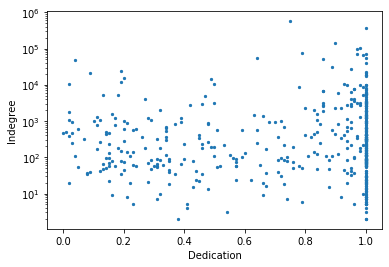

In [17]:
plot_dedication_follower_scatter(df_broadcasters)

In [280]:
n_top_broadcaster = 10
plot_zipf(df_broadcasters_filter, n_top_broadcaster)
plot_zipf_all(df_broadcasters_filter)

In [234]:
data = df_broadcasters_filter['indegree'].values
d_min = 0.5

plot_indegree_pdf(data, d_min)


power law coefficient$ \alpha $ = -1.160


In [221]:
n_top_broadcaster = 20
plot_broad_indegree_distribution(df_broadcasters_filter, df_edges_filter, n_top_broadcaster)


In [273]:
df_broadcasters_filter.sort_values(by='indegree', ascending=False).head(25)

,Id,created_at,dedication,indegree,indegree_removing_outdegree_1_nodes,Rank_indegree,Rank_indegree_removing_outdegree_1_nodes
0,103268673,2015-09-29 10:35:23,0.75,534154,280002,1,1
1,7601562,2009-08-06 19:59:14,1.00,350411,231380,2,2
2,25259668,2011-10-05 02:18:38,0.90,141126,104208,3,3
8,22542277,2011-05-22 07:50:45,0.97,98633,48114,4,9
3,151283108,2017-03-23 20:27:06,0.98,89571,82215,5,4
5,180671441,2017-11-06 03:23:44,0.79,70579,55268,6,6
6,75322837,2014-11-16 17:51:15,1.00,68102,54213,7,7
4,104410233,2015-10-15 03:55:33,0.97,65298,58895,8,5
7,117495462,2016-03-02 02:19:12,0.99,58844,48148,9,8
9,194430943,2018-02-02 22:11:43,1.00,53043,43263,10,10


In [228]:
n_top_broadcsters2exclude = 4
plot_followers_outdegree_distribution(df_broadcasters_filter, df_edges_filter, n_top_broadcsters2exclude)

Maximum outdegree d = 158
95-percentile d = 6
99-percentile d = 14


In [236]:
n_top_broadcsters = 20

# filter by dedication, date as set in filtering = {'dedication': x * 100%, 'date' :'year-month-day'}
plot_heatmap(df_broadcasters, df_edges, df_broadcasters_filter, df_edges_filter,
                 n_top_broadcsters, filter_outdegree_1_nodes=False)

In [237]:
# filter by dedication, date as set in filtering = {'dedication', 'date'}
# but also consider filter_outdegree_1_nodes = True
n_top_broadcsters = 20
plot_heatmap(df_broadcasters, df_edges, df_broadcasters_filter, df_edges_filter,
                 n_top_broadcsters, filter_outdegree_1_nodes=True)

In [124]:
n_top_broadcsters = 10
time_span = pd.date_range(start="2019-01-01", end="2020-11-01", freq='M', tz='UTC')  # every X months
plot_rank_evolution(df_broadcasters_filter, df_edges_filter, time_span, n_top_broadcsters)

In [48]:
# first edge for each broadcaster

plot_first_connection(df_edges)

In [275]:
# peaks at June and Sept
# first peak: https://www.chess.com/article/view/chesscom-pogchamps
# second peak: https://www.chess.com/article/view/next-pogchamps-all-the-information
# new peak? in the near future

time_span = {'begin': pd.to_datetime('2017-01-01', utc=True), 'end':pd.to_datetime('2020-11-01', utc=True)}
plot_growth(df_edges,time_span)

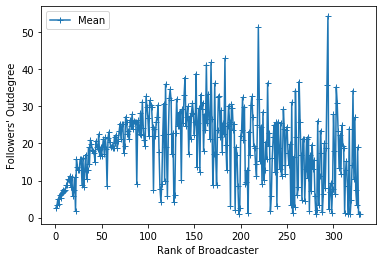

In [27]:
plot_average_outdegree(df_broadcasters_filter, df_edges_filter)

In [ ]:


#for pogchamp event
edge_db = '{}.db'.format(game)
conn = sqlite3.connect(edge_db)
c = conn.cursor()
sources = c.execute("select source FROM edges_db where target = 7601562 and date >= '2020-06-05' and date <= '2020-06-19'").fetchall()
sources = tuple(ele[0] for ele in sources)

from twitch import TwitchClient
from twitchAPI.twitch import Twitch
from tqdm import tqdm

client_v5 = TwitchClient(client_id='x5chjai5leju0kgmqu4fh8l6hc5ycu', oauth_token='csopzwzqls7ogl2e35jvjm089gbyth')
twitch = Twitch('x5chjai5leju0kgmqu4fh8l6hc5ycu', 'csopzwzqls7ogl2e35jvjm089gbyth')
twitch.authenticate_app([])
# get 16 players id
users = twitch.get_users(logins=['moistcr1tikal','forsen','xqcow','boxbox','voyboy','yassuo','swiftor','natehill','papaplatte','xchocobars','hutch','fuslie','ludwig','nymn','erobb221','itssliker'])
users_id = [user['id'] for user in users['data']]
users_id = set(users_id)

stolen_follower = 0
stolen_from = {key: 0 for key in users_id}
# get each follower's followees
for source in tqdm(sources):
    users_followed = twitch.get_users_follows(from_id=source, first=100)
    followed_id = [user['to_id'] for user in users_followed['data']]
    followed_id = set(followed_id)

    intersection_ids = users_id & followed_id
    if intersection_ids:
        stolen_follower += 1
        for id in intersection_ids:
            stolen_from[id] += 1

df = pd.DataFrame(stolen_from.items(), )
ax = df.plot(kind='bar', legend=None)
plt.xlabel('Broadcaster')
plt.ylabel('stolen #Follower')
plt.title('total followers growth from Chess.com:{} with {}% stolen'.format(len(sources),round(100* stolen_follower/len(sources)),2))


